# Assignment 4

## Problem 1 [20 Points]:

Deeplearning has great potential at making in-roads with traditional scientific and engineering research. In this question, we'll consider one good example of this where we'll be performing some predictions working with the [Higgs Dataset](http://mlphysics.ics.uci.edu/data/higgs/) which has been generated from Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. Note that this dataset consists of 11 million datapoints. We'll be using a subset of these for training as described below.

Our classification task is that given the 28 features, we want to predict whether the observation is a “signal” (class 1) or the background (class 0). Perform an 80:20 split of the data into training and testing. Before passing your inputs to the model, normalize your inputs to have zero mean and unit variance.

Build a model using ReLU for activation and glorot-normal initialization. Use binary cross entropy as the loss function, and perform the optimization using the Adam optimizer with default settings. Train your model till you observe a convergence of the loss curves. Plot curves showing evolution of the loss and accuracy when evaluated over the training and the testing data. Consider a 2 layer MLP of width 64.

- Consider your dataset to be randomly selected 1100 data-points from the main dataset. Perform the train / test split on this subset and use these for training your model. What do you observe in this case?
- Consider your dataset to be randomly selected 110000 data-points from the main dataset. Again, perform the train / test split on this subset and use these for training your model. Do your results differ from the earlier case? 
- One way to quantify overfitting is by understanding how sensitive the function is to input noise. For any function f(x), we have that the sensitivity can be computed as
$$\int \left(\frac{df}{dx}\right)^2 p(x) dx = \mathbb{E}((f')^2)$$
This can be estimated by adding some small noise $w$ to the input $x$. For a small enough noise, we have that:
$$f(x + w) \approx f(x) + \frac{df}{dx} w$$ 
We can choose the noise to be drawn from a normal distribution with mean 0 and variance $\sigma^2(w)$. The variance of $f(x + w)$ is given by:
$$\sigma^2(f(x + w)) = \sigma^2(f(x) + f'(x)w) = \sigma^2(f) + \sigma^2(w) \mathbb{E}((f')^2)$$
Using this strategy, estimate the sensitivity of the 2 models you trained earlier. Note that you need to estimate over several trials and take the average. Is it consistent with your findings?


In [2]:
import h5py
import jax
import jax.numpy as jnp
import numpy as onp
import seaborn as sns
from jax import random, jit, vmap, grad, device_put
from jax.example_libraries.optimizers import optimizer, make_schedule, exponential_decay
from jax.example_libraries import stax, optimizers
from jax.example_libraries.stax import Dense, Conv, Relu, MaxPool, Flatten, Softmax, BatchNorm
from scipy.integrate import odeint

import itertools
from functools import partial
from tqdm.notebook import trange
from torch.utils import data
import matplotlib.pyplot as plt

In [3]:
np = jnp
def MLP(layers, activation=jax.nn.relu, initializer=jax.nn.initializers.glorot_normal()):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            W = initializer(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply

In [4]:
from jax.example_libraries.optimizers import optimizer, make_schedule, exponential_decay
@optimizer
def sgd(step_size):
    step_size = make_schedule(step_size)
    def init(x0):
        return x0
    def update(i, g, x):
        return x - step_size(i) * g
    def get_params(x):
        return x
    return init, update, get_params

@optimizer
def adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = make_schedule(step_size)
    def init(x0):
        m0 = np.zeros_like(x0)
        v0 = np.zeros_like(x0)
        return x0, m0, v0
    def update(i, g, state):
        x, m, v = state
        m = (1 - b1) * g + b1 * m  # First  moment estimate.
        v = (1 - b2) * np.square(g) + b2 * v  # Second moment estimate.
        mhat = m / (1 - np.asarray(b1, m.dtype) ** (i + 1))  # Bias correction.
        vhat = v / (1 - np.asarray(b2, m.dtype) ** (i + 1))
        x = x - step_size(i) * mhat / (np.sqrt(vhat) + eps)
        return x, m, v
    def get_params(state):
        x, _, _ = state
        return x
    return init, update, get_params

In [5]:
class MLPregression:
    # Initialize the class
    def __init__(self, layers,
                 rng_key=random.PRNGKey(0)\
                ):
        
        # MLP init and apply functions
        self.net_init, self.net_apply = MLP(layers)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.train_loss_log = []
        self.test_loss_log = []
        self.train_acc_log = []
        self.test_acc_log = []

    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.net_apply(params, inputs)
        log_p = jax.nn.log_sigmoid(outputs)
        # log(1 - sigmoid(x)) = log_sigmoid(-x)
        log_not_p = jax.nn.log_sigmoid(-outputs)

        return np.mean(-targets * log_p - (1. - targets) * log_not_p)
   
    @partial(jit, static_argnums=(0,))
    def accuracy(self, params, batch):
        inputs, targets = batch
        outputs = np.round(jax.nn.sigmoid(self.net_apply(params, inputs)))
        return np.mean(outputs == targets)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, train_dataset, eval_train_dataset, 
              eval_test_dataset, nIter = 10):
        train_data = iter(train_dataset)
        eval_train_data = iter(eval_train_dataset)
        eval_test_data = iter(eval_test_dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            train_batch = next(train_data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, train_batch)  
            if it % 50 == 0:
                # Logger
                eval_train_batch = next(eval_train_data)
                eval_test_batch = next(eval_test_data)

                params = self.get_params(self.opt_state)
                train_loss = self.loss(params, eval_train_batch)
                test_loss = self.loss(params, eval_test_batch)
                train_acc = self.accuracy(params, eval_train_batch)
                test_acc = self.accuracy(params, eval_test_batch)
                self.train_loss_log.append(train_loss)
                self.test_loss_log.append(test_loss)
                self.train_acc_log.append(train_acc)
                self.test_acc_log.append(test_acc)
                pbar.set_postfix({'Train Loss': train_loss, 
                                  'Test Loss': test_loss,
                                  'Train Accuracy': train_acc,
                                  'Test Accuracy': test_acc
                                 })

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [6]:
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, 
                 norm_const=((0.0, 1.0), (0.0, 1.0)), 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.norm_const = norm_const
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        (mu_X, sigma_X), (mu_Y, sigma_Y) = self.norm_const
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[idx,:]
        targets = Y[idx,:]
        inputs = (inputs - mu_X)/sigma_X
        targets = (targets - mu_Y)/sigma_Y
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [9]:
# Load the data:
h5f = h5py.File("$HOME/HIGGS.h5", 'r')
X   = np.array(h5f['features'][:])
Y   = np.array(h5f['targets'][:])
h5f.close()

# Normalization constants
mu_X, sigma_X = X.mean(0), X.std(0)
# NOTE: We are not normalizing y:
mu_Y, sigma_Y = 0, 1
norm_const = (mu_X, sigma_X), (mu_Y, sigma_Y)

In [10]:
# First, lets consider the dataset with 1100 samples
# Considering 80:20 Split:
N_train1 = int(0.00008 * X.shape[0])
N_test1  = int(0.00002 * X.shape[0])

train_X1, test_X1 = X[:N_train1], X[N_train1:(N_train1 + N_test1)]
train_Y1, test_Y1 = Y[:N_train1], Y[N_train1:(N_train1 + N_test1)]

rng_key        = random.PRNGKey(0)
train_dataset1 = DataGenerator(train_X1, train_Y1, norm_const, batch_size = 2**6)

# Considering a larger batch for evaluation:
eval_train_dataset1 = DataGenerator(train_X1, train_Y1, norm_const, batch_size = 2**6)
eval_test_dataset1  = DataGenerator(test_X1, test_Y1, norm_const, batch_size =  2**6)

# Constructing the dataset with 110000 samples:
# Considering 80:20 Split:
N_train2 = int(0.008 * X.shape[0])
N_test2  = int(0.002 * X.shape[0])

train_X2, test_X2 = X[:N_train2], X[N_train2:(N_train2 + N_test2)]
train_Y2, test_Y2 = Y[:N_train2], Y[N_train2:(N_train2 + N_test2)]

rng_key        = random.PRNGKey(0)
train_dataset2 = DataGenerator(train_X2, train_Y2, norm_const, batch_size = 2**6)

# Considering a larger batch for evaluation:
eval_train_dataset2 = DataGenerator(train_X2, train_Y2, norm_const, batch_size = 2**6)
eval_test_dataset2  = DataGenerator(test_X2, test_Y2, norm_const, batch_size =  2**6)

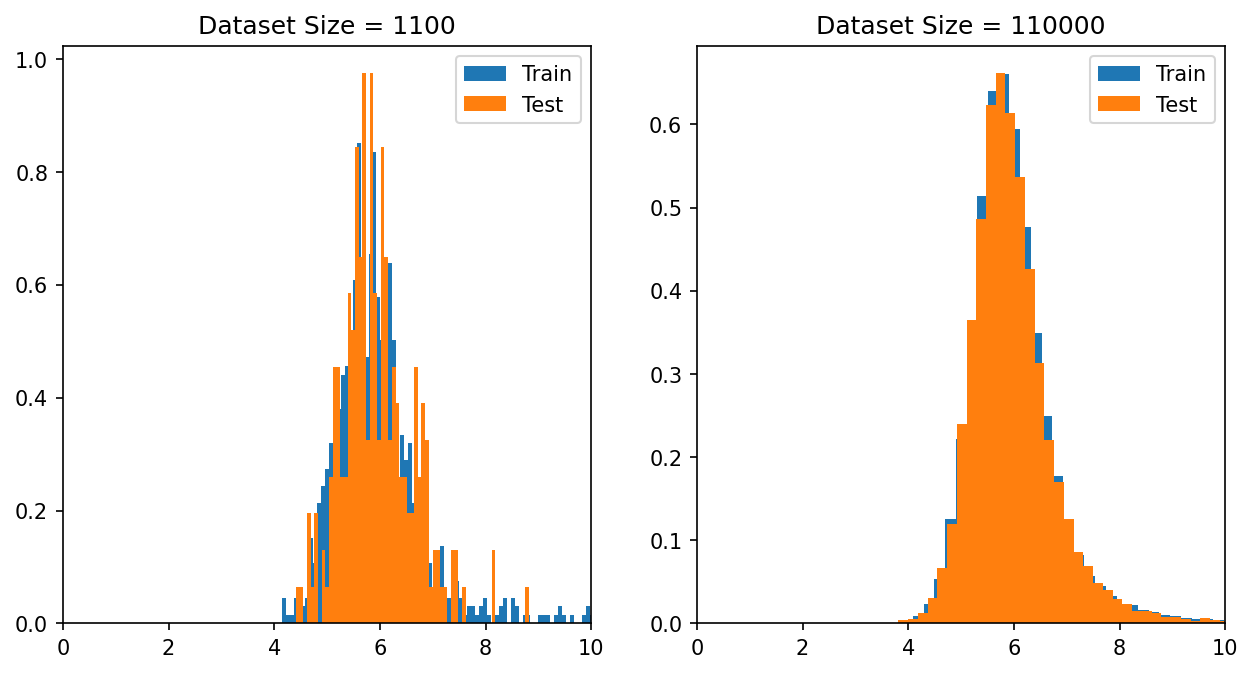

In [14]:
# First, let's visualize the distribution of the training and test data:
# Ideally, we would like the distributions to be similar:
# What do you observe when you change the number of samples?
# Check that train and test datasets are similar looking in distribution:
plt.figure(dpi = 150, figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.title('Dataset Size = 1100')
plt.hist(onp.linalg.norm(train_X1, axis = 1), 100, density = True, label = 'Train')
plt.hist(onp.linalg.norm(test_X1, axis = 1), 100, density = True, label = 'Test')
plt.xlim([0, 10])
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Dataset Size = 110000')
plt.hist(onp.linalg.norm(train_X2, axis = 1), 100, density = True, label = 'Train')
plt.hist(onp.linalg.norm(test_X2, axis = 1), 100, density = True, label = 'Test')
plt.xlim([0, 10])
plt.legend()

In [17]:
# Building our models:
# One we will train on the smaller dataset and the other on the larger dataset:
model1 = MLPregression([28, 64, 64, 1])
model2 = MLPregression([28, 64, 64, 1])

# Training the models:
model1.train(train_dataset1, eval_train_dataset1, eval_test_dataset1, nIter=20000)
model2.train(train_dataset2, eval_train_dataset2, eval_test_dataset2, nIter=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

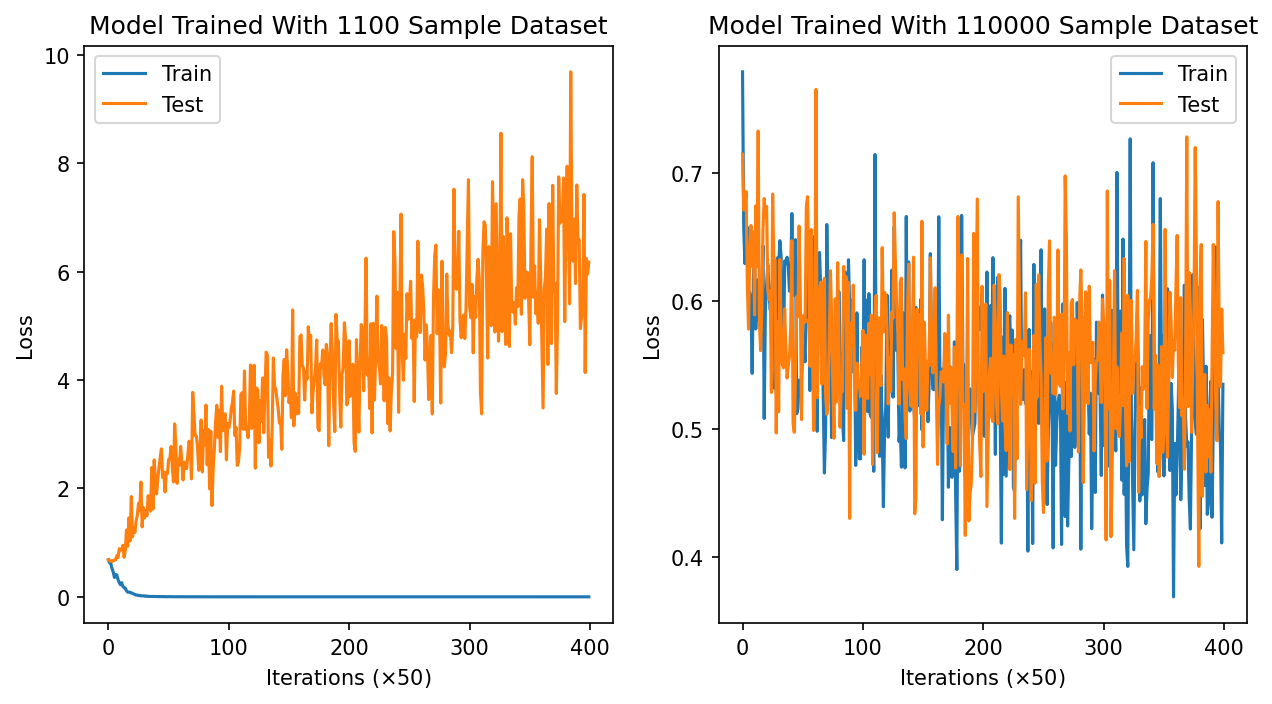

In [20]:
plt.figure(dpi = 150, figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.title('Model Trained With 1100 Sample Dataset')
plt.plot(np.array(model1.train_loss_log), label = 'Train')
plt.plot(np.array(model1.test_loss_log), label = 'Test')
plt.xlabel(r'Iterations ($\times 50$)')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Model Trained With 110000 Sample Dataset')
plt.plot(np.array(model2.train_loss_log), label = 'Train')
plt.plot(np.array(model2.test_loss_log), label = 'Test')
plt.xlabel(r'Iterations ($\times 50$)')
plt.ylabel('Loss')
plt.legend()

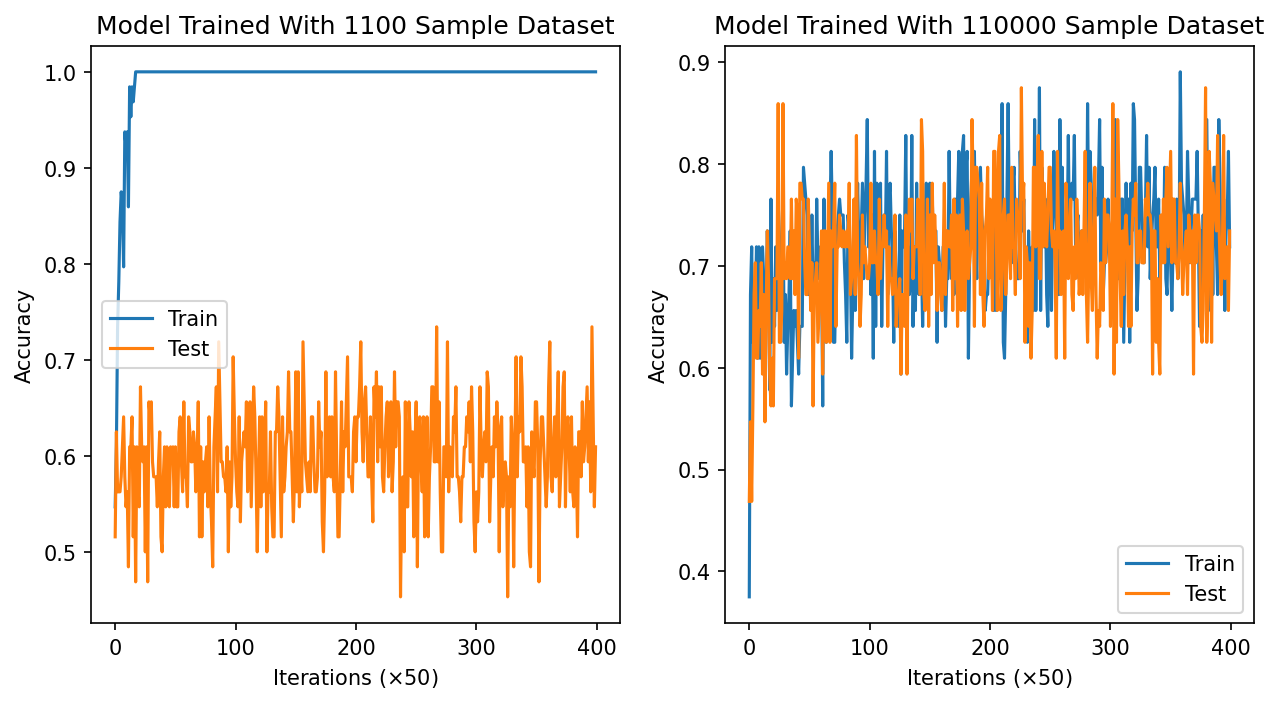

In [21]:
plt.figure(dpi = 150, figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.title('Model Trained With 1100 Sample Dataset')
plt.plot(np.array(model1.train_acc_log), label = 'Train')
plt.plot(np.array(model1.test_acc_log), label = 'Test')
plt.xlabel(r'Iterations ($\times 50$)')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Model Trained With 110000 Sample Dataset')
plt.plot(np.array(model2.train_acc_log), label = 'Train')
plt.plot(np.array(model2.test_acc_log), label = 'Test')
plt.xlabel(r'Iterations ($\times 50$)')
plt.ylabel('Accuracy')
plt.legend()

In [22]:
# Printing Maximum Accuracy (%) Observed Over Test Set:
print('For Model Trained on 1100 Sample Dataset:', 100 * np.array(model1.test_acc_log).max())
print('For Model Trained on 110000 Sample Dataset:', 100 * np.array(model2.test_acc_log).max())

For Model Trained on 1100 Sample Dataset: 73.4375
For Model Trained on 110000 Sample Dataset: 87.5


In [27]:
# Studying the sensitivity of the model to the number of samples:
# Estimating E((f')^2)
val1 = 0
val2 = 0
# Setting standard deviation of the noise:
std_w = 0.1

n_trials = 1000
for i in range(n_trials):
    val1 += (   jnp.std(model1.predict(model1.get_params(model1.opt_state), test_X1 + onp.random.randn(*test_X1.shape) * std_w)) 
              - jnp.std(model1.predict(model1.get_params(model1.opt_state), test_X1))) / std_w**2
    val2 += (   jnp.std(model2.predict(model2.get_params(model2.opt_state), test_X2 + onp.random.randn(*test_X2.shape) * std_w)) 
              - jnp.std(model2.predict(model2.get_params(model2.opt_state), test_X2))) / std_w**2

print("Estimate of E((f')^2) for Model Trained on 1100 Sample Dataset:", val1 / n_trials)
print("Estimate of E((f')^2) for Model Trained on 110000 Sample Dataset:", val2 / n_trials)

Estimate of E((f')^2) for Model Trained on 1100 Sample Dataset: 23.923084
Estimate of E((f')^2) for Model Trained on 110000 Sample Dataset: 2.6890097



## Problem 2 [20 Points]:

Train a convolutional neural network on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The network architecture should be as follows:

- Input layer: Accepts 32x32x3 images
- Convolution layer: 6 filters, filter size 5x5x3, stride 1
- ReLU layer: Accepts and returns a 32x32x6 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Convolution layer: 12 filters, filter size 5x5x6, stride 1
- ReLU layer: Accepts and returns a 16x16x12 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Convolution layer: 24 filters, filter size 5x5x12, stride 1
- ReLU layer: Accepts and returns a 8x8x24 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Fully connected network with 2 hidden layers: Accepts a flattened tensor of dimension 4x4x24 and outputs a 10-dimensional tensor containing the predicted class labels. The layer dimensions should be [384,120,84,10].

Notice how in each layer the number of filters is doubled, while the feature resolution is halved (_hint: make sure you use the appropriate amount of padding to achieve this_). Use the multi-class cross entropy loss function and the Adam optimizer with a learning rate of $10^{-3}$. Train the network for a total of 20000 iterations using a batch size of 128 images. Report the loss as a function of the training iterations, and the resulting confusion matrix for the test data-set. What do you notice here? Propose changes to improve the accuracy over the test set, and verify that you see an improvement of atleast 3% with your changes.


In [28]:
# Using the unpickle function as stated on the website:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

db1 = unpickle('$HOME/data_batch_1')
db2 = unpickle('$HOME/data_batch_2')
db3 = unpickle('$HOME/data_batch_3')
db4 = unpickle('$HOME/data_batch_4')
db5 = unpickle('$HOME/data_batch_5')

In [29]:
# Getting images in the right format, normalizing and composing them together:
imgs1 = db1[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs2 = db2[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs3 = db3[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs4 = db4[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs5 = db5[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs  = np.concatenate([imgs1, imgs2, imgs3, imgs4, imgs5], axis = 0) / 255.0

In [30]:
# Doing the same for the labels, and one hotting the data:
labels1 = np.array(db1[b'labels'])
labels2 = np.array(db2[b'labels'])
labels3 = np.array(db3[b'labels'])
labels4 = np.array(db4[b'labels'])
labels5 = np.array(db5[b'labels'])
labels  = jax.nn.one_hot(np.concatenate([labels1, labels2, labels3, labels4, labels5], axis = 0), 10)

In [31]:
# Architecture
def CNN():
    init, apply = stax.serial(Conv(6, (5, 5), (1, 1), padding="SAME"),
                              Relu,
                              MaxPool((2, 2), (1, 1)),
                              Conv(12, (5, 5), (1, 1), padding="SAME"),
                              Relu,
                              MaxPool((2, 2), (1, 1)),
                              Conv(24, (5, 5), (1, 1), padding="SAME"),
                              Relu,
                              MaxPool((2, 2), (1, 1)),
                              Flatten,
                              Dense(384), Relu,
                              Dense(120), Relu,
                              Dense(84), Relu,
                              Dense(10), Softmax
                             )
    return init, apply

In [32]:
class CNNclassifier:
    # Initialize the class
    def __init__(self, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = CNN()
        _, params = self.net_init(rng_key, (-1, 32, 32, 3))

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=100, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)
        
        # Logger:
        self.itercount = itertools.count()
        # For the training dataset:
        self.loss_log = []
        self.acc_log = []
        # For the testing dataset:
        self.loss_log2 = []
        self.acc_log2 = []

    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch):
        images, labels = batch
        outputs = self.net_apply(params, images)
        loss = -labels * np.log(outputs + 1e-7)
        return np.mean(loss)

    @partial(jit, static_argnums=(0,))
    def accuracy(self, params, batch):
        images, labels = batch
        outputs = self.net_apply(params, images)
        pred_class = np.argmax(outputs,1)
        true_class = np.argmax(labels,1)
        return np.sum((pred_class == true_class)) / images.shape[0]

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, train_dataset, test_dataset, nIter = 10):
        data = iter(train_dataset)
        data_test = iter(test_dataset)
        
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), 
                                       self.opt_state, batch
                                      )  
            if it % 50 == 0:
                batch_test = next(data_test)
                
                # Logger
                params = self.get_params(self.opt_state)
                
                loss = self.loss(params, batch)
                acc = self.accuracy(params, batch)
                
                self.loss_log.append(loss)
                self.acc_log.append(acc)

                loss2 = self.loss(params, batch_test)
                acc2 = self.accuracy(params, batch_test)
                
                self.loss_log2.append(loss2)
                self.acc_log2.append(acc2)

                pbar.set_postfix({'Loss': loss,
                                  'Acc': acc, 
                                  'Loss(test)': loss2,
                                  'Acc(test)': acc2}
                                )

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [33]:
class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [35]:
# Now unloading the test data:
db_test     = unpickle('$HOME/test_batch')
imgs_test   = db_test[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1) / 255.0
labels_test = jax.nn.one_hot(np.array(db_test[b'labels']), 10)

In [36]:
# Create data iterator
train_dataset = DataGenerator(imgs, labels, batch_size=128)
test_dataset = DataGenerator(imgs_test, labels_test, batch_size=128)

In [37]:
# Initialize model
model = CNNclassifier()

In [38]:
# Train model
model.train(train_dataset, test_dataset, nIter = 20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [39]:
opt_params = model.get_params(model.opt_state)
# Evaluating the accuracy at the end of training over the testset:
model.accuracy(opt_params, (imgs_test, labels_test))

DeviceArray(0.625, dtype=float32)

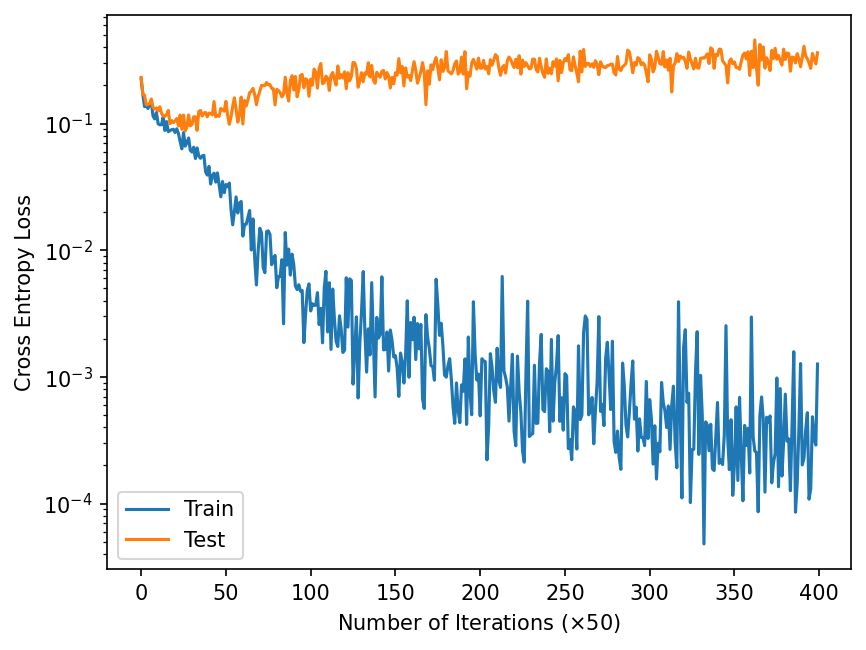

In [40]:
plt.figure(dpi = 150)
plt.xlabel(r'Number of Iterations ($\times 50$)')
plt.ylabel('Cross Entropy Loss')
plt.semilogy(model.loss_log, label = 'Train')
plt.semilogy(model.loss_log2, label = 'Test')
plt.legend()

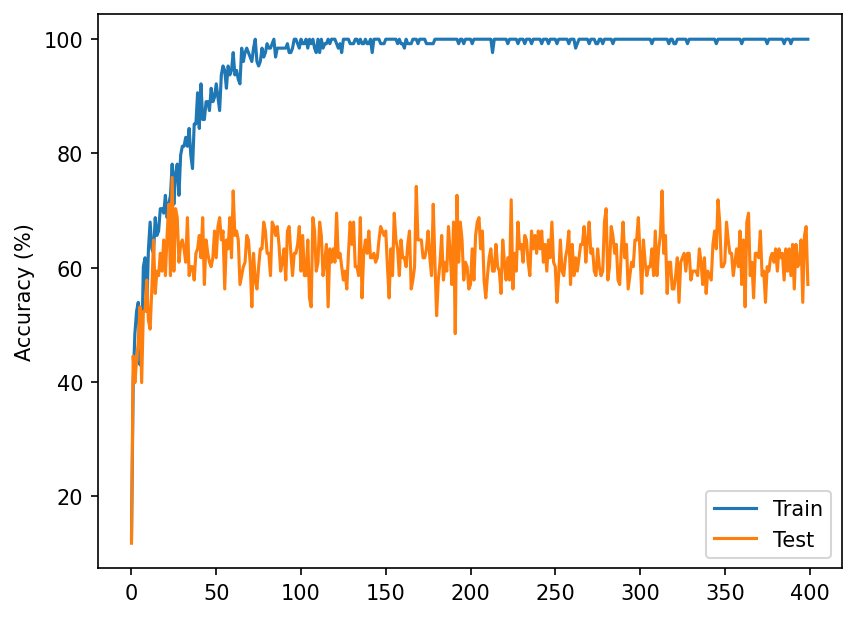

In [41]:
plt.figure(dpi = 150)
plt.ylabel('Accuracy (%)')
plt.plot(np.array(model.acc_log) * 100, label = 'Train')
plt.plot(np.array(model.acc_log2) * 100, label = 'Test')
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix (Test Data)')

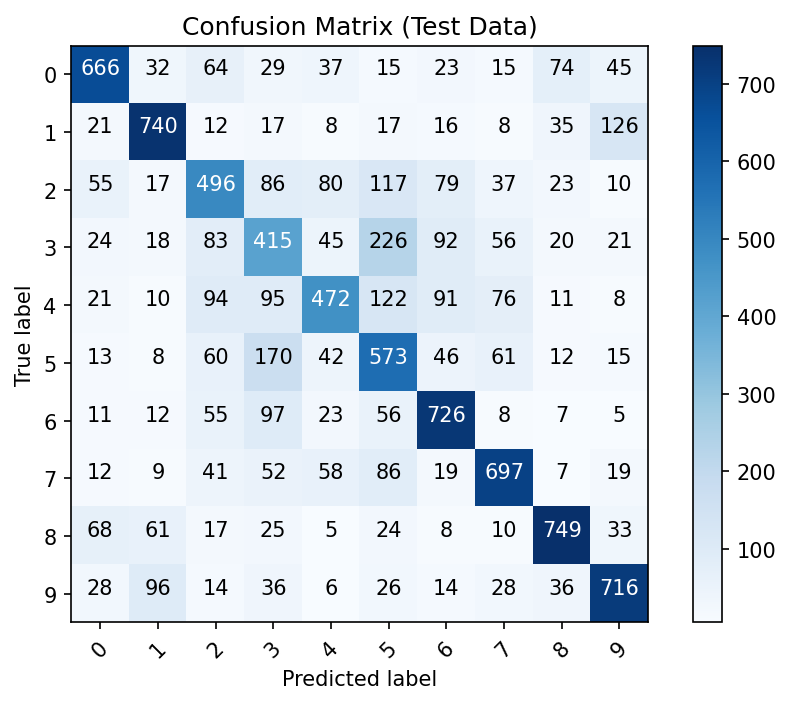

In [43]:
from sklearn.metrics import confusion_matrix
# Plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
outputs = model.predict(opt_params, imgs_test)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(labels_test,1)
M = confusion_matrix(true_class, pred_class)
plt.figure(dpi = 150)
plot_confusion_matrix(M, classes=np.arange(10), normalize=False)
plt.title('Confusion Matrix (Test Data)')

### Improved Results

You can propose several suitable techniques that can be utilized to improve the error - batch normalizations, augmentations, weight decay, different architectures... 

In [44]:
# Performing Image Augmentation:
imgs   = np.concatenate([imgs, 
                         imgs[:, :, ::-1], 
                         imgs[:, ::-1],
                         ])


labels = np.concatenate([labels, 
                         labels, 
                         labels], axis = 0)

In [45]:
# Addition Batch Normalization to our architecture:
def CNN():
    init, apply = stax.serial(Conv(6, (5, 5), (1, 1), padding="SAME"),
                              Relu, BatchNorm(),
                              MaxPool((2, 2), (1, 1)),
                              Conv(12, (5, 5), (1, 1), padding="SAME"),
                              Relu, BatchNorm(),
                              MaxPool((2, 2), (1, 1)),
                              Conv(24, (5, 5), (1, 1), padding="SAME"),
                              Relu, BatchNorm(),
                              MaxPool((2, 2), (1, 1)),
                              Flatten,
                              Dense(384), Relu,
                              Dense(120), Relu,
                              Dense(84), Relu,
                              Dense(10), Softmax
                             )
    return init, apply

In [46]:
# Including weight decay in the loss:
class CNNclassifier:
    # Initialize the class
    def __init__(self, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = CNN()
        _, params = self.net_init(rng_key, (-1, 32, 32, 3))

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=100, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)
        
        # Logger:
        self.itercount = itertools.count()
        # For the training dataset:
        self.loss_log = []
        self.acc_log = []
        # For the testing dataset:
        self.loss_log2 = []
        self.acc_log2 = []

    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch):
        images, labels = batch
        outputs = self.net_apply(params, images)
        loss = -labels * np.log(outputs + 1e-7)
        l2_reg =  0.5 * sum(np.sum(np.abs(p)) for p in jax.tree_leaves(params))
        return np.mean(loss) + 1e-5 * l2_reg

    @partial(jit, static_argnums=(0,))
    def accuracy(self, params, batch):
        images, labels = batch
        outputs = self.net_apply(params, images)
        pred_class = np.argmax(outputs,1)
        true_class = np.argmax(labels,1)
        return np.sum((pred_class == true_class)) / images.shape[0]

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, train_dataset, test_dataset, nIter = 10):
        data = iter(train_dataset)
        data_test = iter(test_dataset)
        
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), 
                                       self.opt_state, batch
                                      )  
            if it % 50 == 0:
                batch_test = next(data_test)
                
                # Logger
                params = self.get_params(self.opt_state)
                
                loss = self.loss(params, batch)
                acc = self.accuracy(params, batch)
                
                self.loss_log.append(loss)
                self.acc_log.append(acc)

                loss2 = self.loss(params, batch_test)
                acc2 = self.accuracy(params, batch_test)
                
                self.loss_log2.append(loss2)
                self.acc_log2.append(acc2)

                pbar.set_postfix({'Loss': loss,
                                  'Acc': acc, 
                                  'Loss(test)': loss2,
                                  'Acc(test)': acc2}
                                )

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [47]:
# Create data iterator
train_dataset = DataGenerator(imgs, labels, batch_size=128)
test_dataset = DataGenerator(imgs_test, labels_test, batch_size=128)

In [48]:
# Initialize model
model = CNNclassifier()

In [49]:
# Train model
model.train(train_dataset, test_dataset, nIter = 20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

/tmp/ipykernel_245730/4265354488.py:30: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  l2_reg =  0.5 * sum(np.sum(np.abs(p)) for p in jax.tree_leaves(params))


In [50]:
# Evaluating the accuracy at the end of training over the testset:
opt_params = model.get_params(model.opt_state)
model.accuracy(opt_params, (imgs_test, labels_test))

DeviceArray(0.6922, dtype=float32)

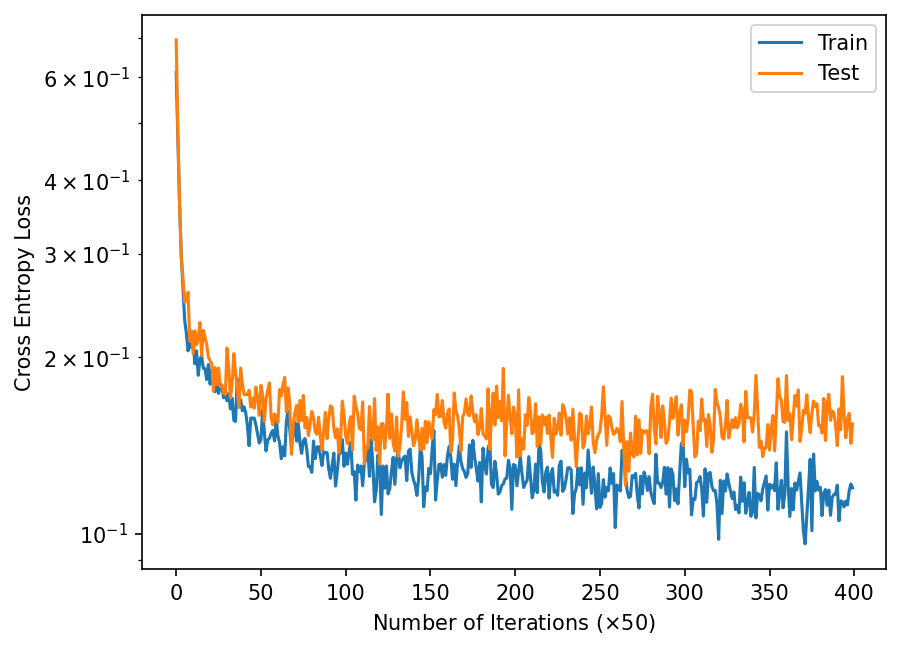

In [51]:
plt.figure(dpi = 150)
plt.xlabel(r'Number of Iterations ($\times 50$)')
plt.ylabel('Cross Entropy Loss')
plt.semilogy(model.loss_log, label = 'Train')
plt.semilogy(model.loss_log2, label = 'Test')
plt.legend()

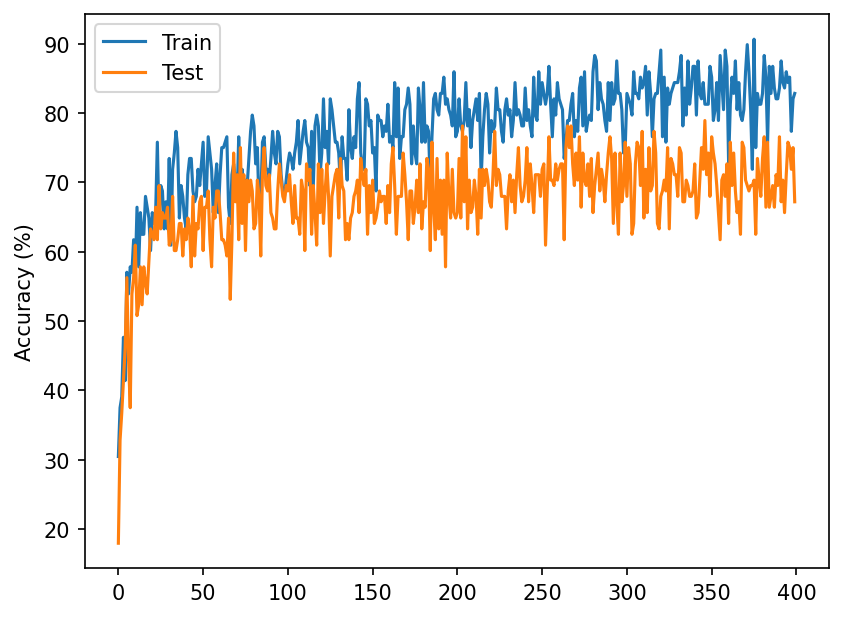

In [52]:
plt.figure(dpi = 150)
plt.ylabel('Accuracy (%)')
plt.plot(np.array(model.acc_log) * 100, label = 'Train')
plt.plot(np.array(model.acc_log2) * 100, label = 'Test')
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix (Test Data)')

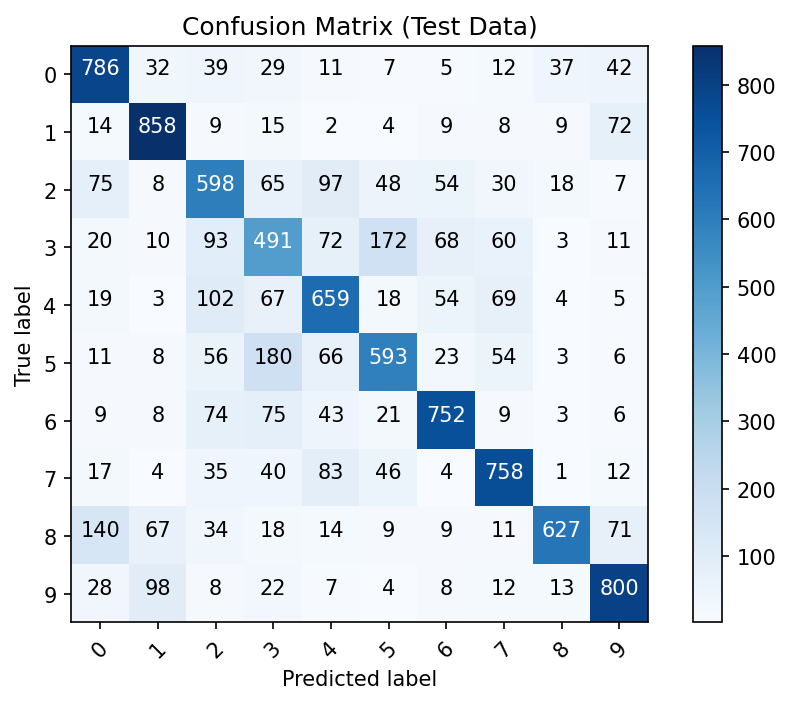

In [53]:
outputs = model.predict(opt_params, imgs_test)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(labels_test,1)
M = confusion_matrix(true_class, pred_class)
plt.figure(dpi = 150)
plot_confusion_matrix(M, classes=np.arange(10), normalize=False)
plt.title('Confusion Matrix (Test Data)')


## Problem 3 [20 Points]:

A subcritically damped pendulum is described by the equation
$$x'' = -\sin(x) - \mu x'$$

where $x$ is the angle of the pendulum and $\mu$ is a damping parameter.

(i) Create a time-series data-set by using [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) to integrate this system in the interval $t\in[0,50]$ using $2,000$ time-steps using an initial condition of $x(t=0) = 0$,  $x'(t=0) = 1.2$. Plot the evolution of the pendulum angle and angular velocity as a function of time.

(ii) Implement an LSTM (Long short-term memory) with 8 lags, one hidden layer with 32 neurons, and a hyperbolic tangent activation function. Train the network using the data-set generated for $20,000$ stochastic gradient descent steps using the Adam optimizer with a learning rate of $10^{-3}$ and a mini-batch size of 128. Use the trained model to perform **one-step-ahead predictions** until the final time $T=60$, and compare them against the true data. Plot the predicted and exact signals, and report their discrepancy within the test interval in the relative $\mathbb{L}_{2}$ norm.


In [64]:
def f(X, t):
    x = X[0]
    y = X[1]
    # Defining xdot and ydot:
    mu = 0.1
    xdot = y
    ydot = -jnp.sin(x) - mu * y
    
    return onp.array([xdot, ydot])

In [65]:
# We are told to integrate [0, 50] with 2000 timesteps:
t_start = 0
t_final = 50
N_t     = 2000
t_eval  = onp.arange(t_start, t_final, (t_final - t_start) / N_t)
# Prescribed initial conditions:
X0 = onp.array([0.0, 1.2])
# Integrating system:
sol = odeint(f, X0, t_eval)

Text(0.5, 1.0, 'Evolution of State Trajectories')

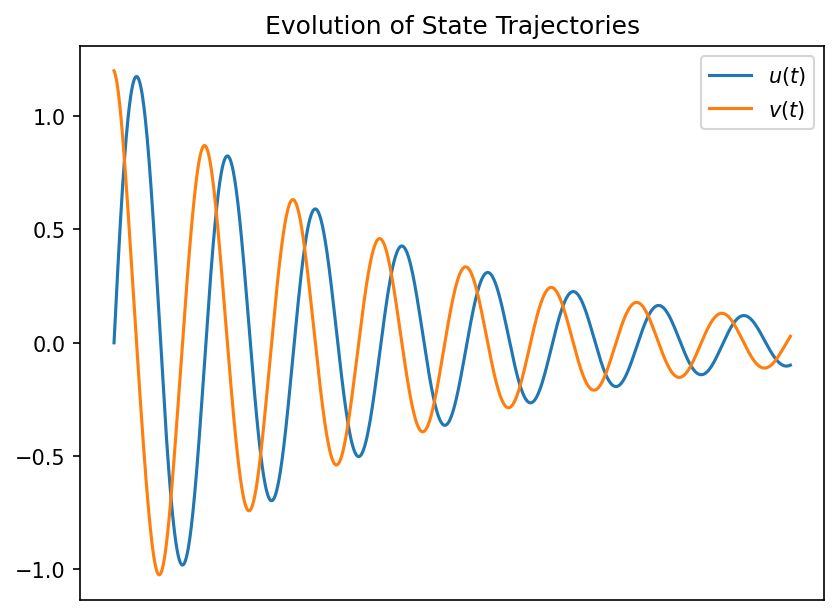

In [66]:
# Plotting the state trajectories:
plt.figure(dpi = 150)
plt.plot(t_eval, sol[:, 0], label = r'$u(t)$')
plt.plot(t_eval, sol[:, 1], label = r'$v(t)$')
plt.xticks([])
plt.legend()
plt.title('Evolution of State Trajectories')

In [67]:
from jax.nn import sigmoid
from jax.lax import scan
# Efficient implementation via lax.scan
def LSTM(depth, dims, activation=np.tanh):
    input_dim, hidden_dim, output_dim = dims
    def init(rng_key):
        def glorot_init(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            return W
        keys = random.split(rng_key, 9)
        W_f = glorot_init(keys[0], input_dim, hidden_dim)
        W_i = glorot_init(keys[1], input_dim, hidden_dim)
        W_o = glorot_init(keys[2], input_dim, hidden_dim)
        W_c = glorot_init(keys[3], input_dim, hidden_dim)
        U_f = glorot_init(keys[4], hidden_dim, hidden_dim)
        U_i = glorot_init(keys[5], hidden_dim, hidden_dim)
        U_o = glorot_init(keys[6], hidden_dim, hidden_dim)
        U_c = glorot_init(keys[7], hidden_dim, hidden_dim)
        b_f = np.zeros(hidden_dim)
        b_i = np.zeros(hidden_dim)
        b_o = np.zeros(hidden_dim)
        b_c = np.zeros(hidden_dim)
        V   = glorot_init(keys[8], hidden_dim, output_dim)
        c   = np.zeros(output_dim)
        return (W_f, W_i, W_o, W_c, U_f, U_i, U_o, U_c, b_f, b_i, b_o, b_c, V, c)

    def scan_fn(params, carry, inputs):
        (H, C) = carry
        W_f, W_i, W_o, W_c, U_f, U_i, U_o, U_c, b_f, b_i, b_o, b_c, V, c = params
        ft = sigmoid(np.dot(inputs, W_f) + np.dot(H, U_f) + b_f)
        it = sigmoid(np.dot(inputs, W_i) + np.dot(H, U_i) + b_i)
        ot = sigmoid(np.dot(inputs, W_o) + np.dot(H, U_o) + b_o)
        ctilde = activation(np.dot(inputs, W_c) + np.dot(H, U_c) + b_c)
        C = ft * C + it * ctilde
        H = ot * activation(C) 
        return (H, C), (H, C)

    def apply(params, inputs):
        W_f, W_i, W_o, W_c, U_f, U_i, U_o, U_c, b_f, b_i, b_o, b_c, V, c = params
        f = partial(scan_fn, params)
        H = np.zeros((inputs.shape[1], hidden_dim))
        C = np.zeros((inputs.shape[1], hidden_dim))
        carry = H, C
        carry, _ = scan(f, carry, inputs)
        H, C = carry
        H = np.dot(H,V) + c
        return H
    return init, apply

In [68]:
class Seq2Seq:
    # Initialize the class
    def __init__(self, depth, dims, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = LSTM(depth, dims)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.net_apply(params, inputs)
        loss = np.mean((targets-outputs)**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [87]:
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[:,idx,:]
        targets = Y[idx,:]
        return inputs, targets

    @partial(jit, static_argnums=(0,))
    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [88]:
def create_lags(data, lags):
    N = len(data)-lags
    data_dim = data.shape[1]
    X = np.zeros((lags, N, data_dim))
    Y = np.zeros((N, data_dim))
    for i in range(N):
        X = X.at[:,i,:].set(data[i:(i+lags),:])
        Y = Y.at[i,:].set(data[i+lags,:])
    return X, Y

In [89]:
# Normalize
mean, std = sol.mean(0), sol.std(0)
norm_sol1 = (sol - mean.reshape(1, -1)) / std.reshape(1, -1)

# Use 2/3 of all data as training Data
train_size = int(norm_sol1.shape[0])
training_data = norm_sol1[0:train_size,:]

# reshape X and Y
# X has the form lags x data x dim
# Y has the form data x dim
lags = 8
X, Y = create_lags(training_data, lags)
dataset = DataGenerator(X, Y, batch_size=128)

In [90]:
# Initialize model
inp_dim = X.shape[-1]
out_dim = Y.shape[-1]
hid_dim = 32
model = Seq2Seq(lags, (inp_dim, hid_dim, out_dim))

  0%|          | 0/2500 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

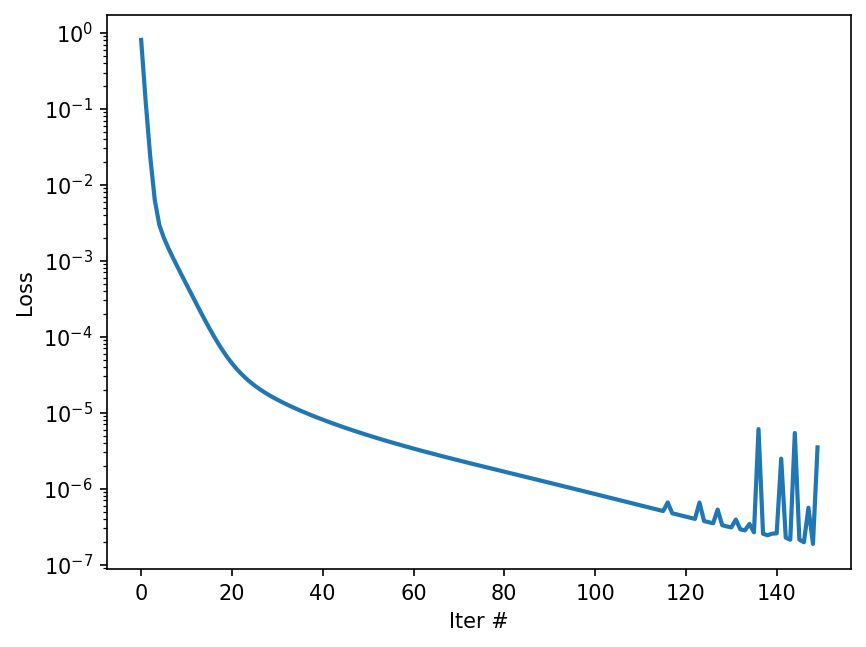

In [96]:
# Train model
model.train(dataset, nIter=10000)
opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure(dpi = 150)
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [97]:
# Evolving till t = 60:
t_ref   = onp.arange(0, 60, (60) / 2400)
sol_ref = odeint(f, X0, t_ref)

In [98]:
# One-step-ahead prediction via lax.scan
def one_step_pred(inputs, step):
    outputs = model.predict(opt_params, inputs)
    inputs = inputs.at[:-1,...].set(inputs[1:,...])
    inputs = inputs.at[-1,...].set(outputs)
    return inputs, outputs[-1,:]

steps = len(sol_ref) - lags
_, outputs = scan(one_step_pred, X[:, 0:1, :], np.arange(steps))

In [99]:
# Computing the error over the test interval (last 400 steps):
print("Relative L2 Error:", (np.linalg.norm(  sol_ref[-400:] 
                                            - (outputs[-400:] * std + mean)
                                            , axis = 0
                                           ) / np.linalg.norm(sol_ref[-400:], axis = 0)).mean()
     )

Relative L2 Error: 0.033820903726038576


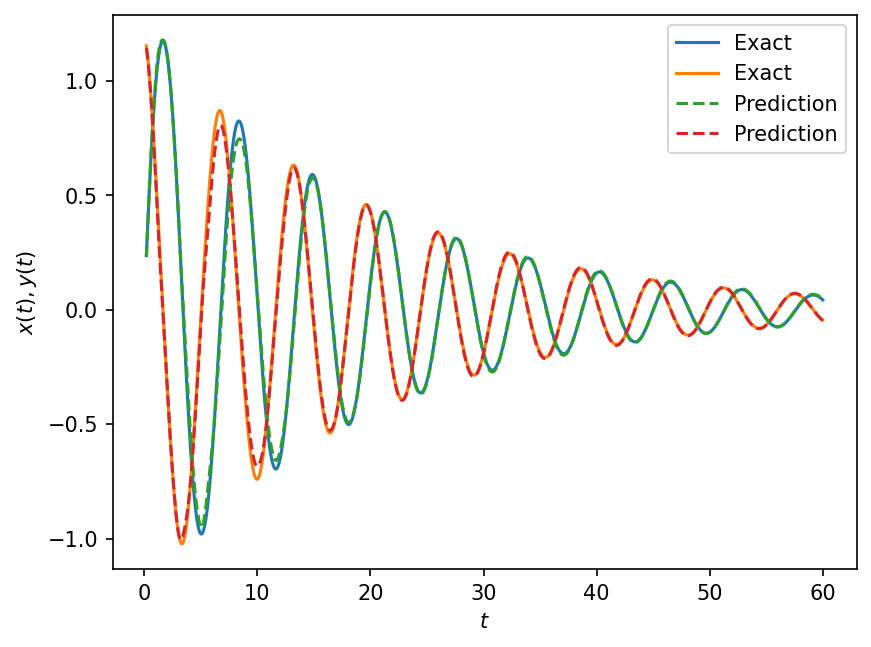

In [100]:
plt.figure(dpi = 150)
plt.plot(t_ref[lags:], sol_ref[lags:], '-', label = "Exact")
plt.plot(t_ref[lags:], outputs * std + mean, '--', label = "Prediction")
plt.xlabel('$t$')
plt.ylabel('$x(t), y(t)$')
plt.legend()


## Problem 4 [20 Points]:

Simulation of complex physical systems described by nonlinear partial differential equations (PDEs) is central to engineering and physical science. We'll now train a neural network to solve a PDE given the boundary conditions. Till now, we have trained an MLP through data and penalize the network until it learns what we desire. However, in the case of PDEs, we can use knowledge of the known PDE to guide the training. Using the core idea of [PINNs](https://www.sciencedirect.com/science/article/pii/S0021999118307125), train a network to solve the Poisson equation 
$$u_{xx} + u_{yy} = -\sin (\pi x) \sin(\pi y)$$
with the following BCs:
$$u(0, y) = u(1, y) = u(x, 1) = u(x, 1) = 0$$

Utilize 10000 collocation points in the domain to enforce the PDE and 100 data-points on each boundary to enforce boundary condition. Compare your solution against the analytic solution and report error in the relative $\mathbb{L}_{2}$ norm.


In [117]:
init_fun, apply_fun = MLP([2, 16, 16, 16, 16, 16, 1], jnp.sin)

In [118]:
rng_key = jax.random.PRNGKey(0)
params = init_fun(rng_key)

In [119]:
def net_u(params, x, y):
    u    = apply_fun(params, jnp.array([x, y]))
    return u[0]

# Evaluating the residual
def net_r(params, x, y):
    u    = net_u(params, x, y)
    u_xx = jax.grad(jax.grad(net_u, 1), 1)(params, x, y)
    u_yy = jax.grad(jax.grad(net_u, 2), 2)(params, x, y)

    # Defining the residual that needs to be satisfied:
    r = u_xx + u_yy + jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)
    return r

In [120]:
def loss_bcs(params, x_bcs, y_bcs):
    loss_bcs = ((jax.vmap(net_u, (None, 0, 0))(params, x_bcs, y_bcs))**2).mean()
    return loss_bcs

def loss_residual(params, x_res, y_res):
    return ((jax.vmap(net_r, (None, 0, 0))(params, x_res, y_res))**2).mean()

@jax.jit
def loss(params, x_bcs, y_bcs, x_res, y_res):
    return loss_bcs(params, x_bcs, y_bcs) + \
           loss_residual(params, x_res, y_res)

# Computing Gradients:
grad_loss = jax.grad(loss)

In [121]:
# Defining number of points used:
N_bcs = 100
N_res = 10000 # ensure that it's a perfect square

In [122]:
# Performing equispaced sampling:
x_bcs = jnp.linspace(0, 1, N_bcs)
y_bcs = jnp.zeros(N_bcs)

x_bcs = jnp.append(x_bcs, jnp.ones(N_bcs))
y_bcs = jnp.append(y_bcs, jnp.linspace(0, 1, N_bcs))

x_bcs = jnp.append(x_bcs, jnp.linspace(0, 1, N_bcs)[::-1])
y_bcs = jnp.append(y_bcs, jnp.ones(N_bcs))

x_bcs = jnp.append(x_bcs, jnp.zeros(N_bcs))
y_bcs = jnp.append(y_bcs, jnp.linspace(0, 1, N_bcs)[::-1])

x_res  = jnp.linspace( 0, 1, int(onp.sqrt(N_res)))
y_res  = jnp.linspace( 0, 1, int(onp.sqrt(N_res)))
# Taking a gridded sample of these points:
x_res, y_res = jnp.meshgrid(x_res, y_res)
x_res, y_res = x_res.ravel(), y_res.ravel()

In [123]:
# Defining Number of Epochs and Learning Rate:
N_iters  = 100000
alpha    = 1e-3

learning_rate = optimizers.exponential_decay(alpha, decay_steps=100, 
                                             decay_rate=0.99
                                             )
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params)
# Define a compiled update step
@jax.jit
def step(i, opt_state, x_bcs, y_bcs, x_res, y_res):
    p = get_params(opt_state)
    g = grad_loss(p, x_bcs, y_bcs, x_res, y_res)
    return opt_update(i, g, opt_state)

In [124]:
loss_history1 = [loss_bcs(params, x_bcs, y_bcs)]
loss_history2 = [loss_residual(params, x_res, y_res)]
loss_history3 = [loss(params, x_bcs, y_bcs, x_res, y_res)]
# Progress Bar:
batch_size = 500
pbar       = trange(N_iters)
for it in pbar:
    # idx       = onp.random.choice(N_res, batch_size, replace = False)
    opt_state = step(it, opt_state, 
                     x_bcs, y_bcs, x_res, y_res
                    )

    if(it % 100 == 0):
        params    = get_params(opt_state)
        loss_history1.append(loss_bcs(params, x_bcs, y_bcs))
        loss_history2.append(loss_residual(params, x_res, y_res))
        loss_history3.append(loss(params, x_bcs, y_bcs, x_res, y_res))

        pbar.set_postfix({'IC/BC Loss':loss_history1[-1].item(),
                          'Residual Loss':loss_history2[-1].item(),
                          'Total Loss':loss_history3[-1].item()
                          })

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
plt.figure(dpi = 150)
plt.semilogy(loss_history1, label = 'BC/IC Loss')
plt.semilogy(loss_history2, label = 'Residual Loss')
plt.semilogy(loss_history3, label = 'Total')
plt.xlabel(r'Number of Iterations ($\times 100$)')
plt.legend()

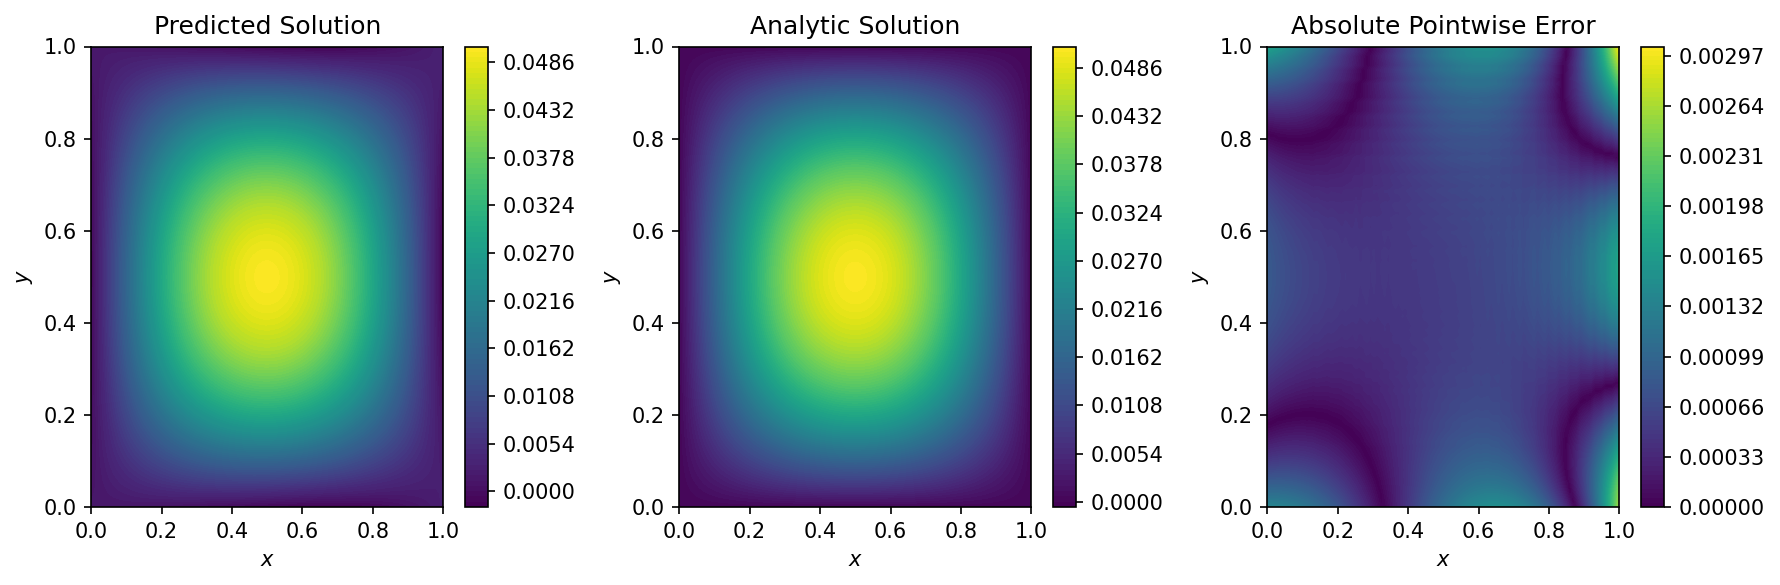

In [125]:
pred = jax.vmap(net_u, (None, 0, 0))(params, x_res, y_res)
ana = jnp.sin(jnp.pi * x_res) * jnp.sin(jnp.pi * y_res) / (2 * jnp.pi**2)

plt.figure(dpi = 150, figsize = (12, 4))
plt.subplot(1, 3, 1)
plt.title('Predicted Solution')
plt.contourf(x_res.reshape(100, 100), y_res.reshape(100, 100), pred.reshape(100, 100), 100)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.subplot(1, 3, 2)
plt.title('Analytic Solution')
plt.contourf(x_res.reshape(100, 100), y_res.reshape(100, 100), ana.reshape(100, 100), 100)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.subplot(1, 3, 3)
plt.title('Absolute Pointwise Error')
plt.contourf(x_res.reshape(100, 100), y_res.reshape(100, 100), abs(pred - ana).reshape(100, 100), 100)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.tight_layout()


## Problem 5 [20 Points]:

Submit a two-page summary of your proposed final project. Make sure you clearly articulate the following:
- An overview of the proposed problem and why it is important.
- What are the challenges to be addressed.
- What is the current state-of-the-art and which are its potential limitations.
- What is the formal mathematical definition of the problem, and what is the technical approach you will employ.
- What is the potential impact upon the successful completion of the project.

Any figures or references should be included within the 2-page limit.

